In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import math
import geopandas as gpd
import shapely

In [304]:
def convertGeometries(df):
    for i in list(df.index):
        geom_type = df.loc[i, 'GeometryType']
#         print(geom_type)
        geom = None
        if geom_type == 'Point':
            geom = shapely.geometry.Point(df.loc[i,'Coordinates'])
        elif geom_type == 'GeometryCollection':
            if df.loc[i,'Coordinates'][0] == df.loc[i,'Coordinates'][-1]:
                geom = shapely.geometry.Polygon(df.loc[i,'Coordinates'])
            else:
                geom = shapely.geometry.LineString(df.loc[i,'Coordinates'])
        df.loc[i, 'geometry'] = geom

In [305]:
df = pd.read_csv('../data-versions/navwarnings-dates-centroids.csv')#.sample(frac=0.1).reset_index()
# df = df.sample(frac=0.05)
df = df.drop(columns=['Unnamed: 0'])
df = df.drop(df[df['lon_centroid'] < -180].index)
df = df.drop(df[df['lon_centroid'] > 180].index)
df = df.drop(df[df['lat_centroid'] < -90].index)
df = df.drop(df[df['lat_centroid'] > 90].index)

df['StartDate'] = pd.to_datetime(df['StartDate'])
df['EndDate'] = pd.to_datetime(df['EndDate'])
df['BroadcastingDate'] = pd.to_datetime(df['BroadcastingDate'])
df['Coordinates'] = df['Coordinates'].apply(lambda c: eval(c))
# convertGeometries(df)

In [306]:
df['geometry'] = pd.Series(np.zeros(len(df)), index=df.index)

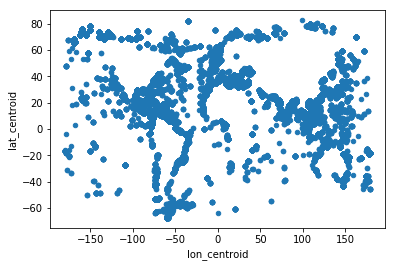

In [307]:
df[['lon_centroid', 'lat_centroid']].plot.scatter('lon_centroid', 'lat_centroid')

In [308]:
df_sample = df.sample(frac=0.1)
df_s = df_sample.sample(frac=0.01)

In [344]:
class RiskGrid:
    
    
    def __init__(self, df):
        self.observations = df
        self.kde = {}
#         self.quadrats = {}
    
    def getObservations(self):
        return self.observations

    def quadrat(self, cellSize):
        
#         if str(cellSize) in self.quadrats:
#             return self.quadrats[str(cellSize)]
    
        df = self.observations
        
        lats = np.arange(-90, 90 + cellSize, cellSize, dtype=np.single)
        lons = np.arange(-180, 180 + cellSize, cellSize, dtype=np.single)
        
        multiindex = pd.MultiIndex.from_product([lons.tolist(), lats.tolist()], names=['lons', 'lats'])
        grid = gpd.GeoDataFrame(index=multiindex, columns = ['geometry'])
        grid['risk'] = gpd.GeoSeries(np.zeros(len(grid.index)), index=grid.index)

        # Create boxes 
        for i in lats:
            for c in lons:
                box = shapely.geometry.box(c, i, c + cellSize, i + cellSize)
                grid.loc[(c,i), 'geometry'] = box
        
        
        # Basic quadrat method
        # Perhaps a more efficient way with intersects?
        for row in df.iterrows():
            x = float(row[1]['lon_centroid'] ) + 180
            y = float(row[1]['lat_centroid'] ) + 90

            x = x - x % cellSize
            y = y - y % cellSize

            grid.loc[(x - 180, y - 90), 'risk'] += 1
        
        # Normalize 'risk' by dividing each record by the sum of all
        # Then we have something related to probability

        self.quadrats = grid
        return grid

    
    def spatialKDE(self, bandwidth=0.04, xbins=500j, ybins=500j, **kwargs): 
        """Build 2D kernel density estimate (KDE).
            Adapted from @geoff, https://stackoverflow.com/questions/41577705/how-does-2d-kernel-density-estimation-in-python-sklearn-work
        """
        
        if str(bandwidth) in self.kde:
            k = self.kde[str(bandwidth)]
            return k.kde, k.xx, k.yy, k.zz
        
        from sklearn.neighbors import KernelDensity
        
        df = self.observations
        x = df['lon_centroid'].values * math.pi / 180. # as radians
        y = df['lat_centroid'].values * math.pi / 180.
        
        # create grid of sample locations (default: 100x100)
        # could also hard code this to be -pi : pi, -pi / 2 : pi / 2
        xx, yy = np.mgrid[x.min():x.max():xbins, 
                          y.min():y.max():ybins]

        xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
        xy_train  = np.vstack([y, x]).T

        if bandwidth == 0 or bandwidth == 'silverman':
            # Silverman, from 
            # https://gist.github.com/daleroberts/7a13afed55f3e2388865b0ec94cd80d2
            
            d = xy_train.shape[0]
            n = xy_train.shape[1]
            bandwidth = (n * (d + 2) / 4.)**(-1. / (d + 4))
            self.silverman_bw = bandwidth
            
        kde_skl = KernelDensity(bandwidth=bandwidth, metric='haversine', **kwargs)
        kde_skl.fit(xy_train)

        # score_samples() returns the log-likelihood of the samples
        z = np.exp(kde_skl.score_samples(xy_sample))
        zz = np.reshape(z, xx.shape)
        
        self.kde[str(bandwidth)] = {
            'xx': xx,
            'yy': yy,
            'zz': zz,
            'kde': kde_skl
        }
        
        return kde_skl, xx, yy, zz
    
    def showKDE(self, bandwidth=0):
        kde = self.kde[str(0.04)]

        df = self.observations        
        x = df['lon_centroid'].values * math.pi / 180. # as radians
        y = df['lat_centroid'].values * math.pi / 180.
    
        plt.figure(figsize=(15,10))
        
        ax = plt.gca()
        ax.set_xlim([kde['xx'].min(), kde['xx'].max()])
        ax.set_ylim([kde['yy'].min(), kde['yy'].max()])

        plt.pcolormesh(kde['xx'], kde['yy'], kde['zz'], cmap='Reds')
        plt.scatter(x, y, s=2, facecolor='white')
        gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).plot(ax=ax, color='white', edgecolor='gray')

        
    def getKDEs(self):
        return self.kde


    # Include polygons in risk map? rather than just centroids ...
    
    def showRiskGrid(self):
        f, ax = plt.subplots(1, figsize=(20,25))
        base = self.quadrats.plot(ax=ax, column='risk', cmap='Reds', alpha= 0.5);
        gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).plot(ax=ax, color='white', edgecolor='gray')
        ax.scatter(self.observations['lon_centroid'], self.observations['lat_centroid'])
        
    
    def calcRiskScoreQuadrat(self, line):
        
        if type(line) is not shapely.geometry.linestring.LineString:
            print("Please pass a shapely Linestring in decimal degrees")
            return
        
        # Check estimation method, generate risk score based on that method
        g = self.quadrats
        
        # Check if line is list, shapely LineString
        # make sure it's a shapely LineString

        mask = g['geometry'].intersects(line)
        lengths = g[mask].intersection(line).length
        risks = lengths * g['risk']
        return risks, risks[risks > 0].sum()
    
    def calcRiskScoreKDE(self, line, sampleFrequency=0.01):
        
        if type(line) is not shapely.geometry.linestring.LineString:
            print("Please pass a shapely Linestring in decimal degrees")
            return
        
        
        lineDegrees = np.array(list(line.coords))
        lineDegrees.T[0] *= math.pi / 180.
        lineDegrees.T[1] *= math.pi / 180.
        lineRadians = lineDegrees

        routeLine = shapely.geometry.LineString(lineRadians)

        riskSample = np.arange(0, routeLine.length, sampleFrequency) # sampleFrequency in radians: ~ every 63.78 km - (https://www.translatorscafe.com/unit-converter/en/length/7-89/kilometer-Earth%E2%80%99s%20equatorial%20radius/)
        zeros = np.zeros(len(riskSample))

        risks = pd.DataFrame(data={'along': riskSample, 'lat': zeros, 'lon': zeros, 'risk_score': zeros})
        risks['lon'] = risks.apply(lambda row: list(routeLine.interpolate(row['along']).coords)[0][0], axis=1)
        risks['lat'] = risks.apply(lambda row: list(routeLine.interpolate(row['along']).coords)[0][1], axis=1)
        risks['risk_score'] = risks.apply(lambda row: np.exp(kde.score_samples([[row['lon'], row['lat']]]))[0], axis=1)
    
        return risks
    

In [345]:
r = RiskGrid(df_s)

In [346]:
q = r.quadrat(10)

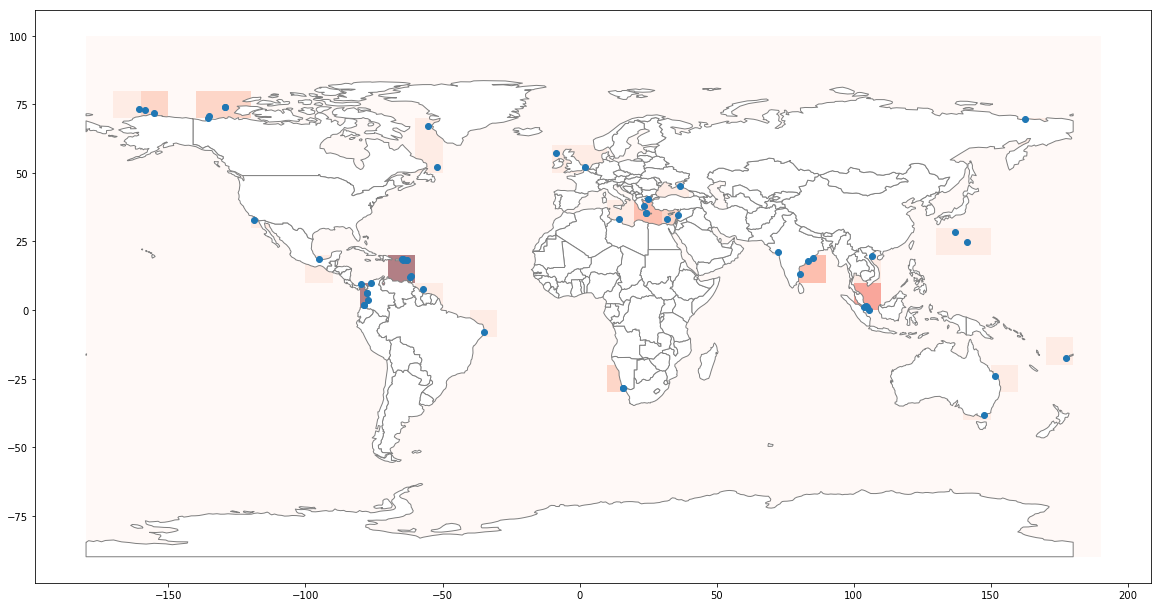

In [347]:
r.showRiskGrid()

In [349]:
k = r.spatialKDE()

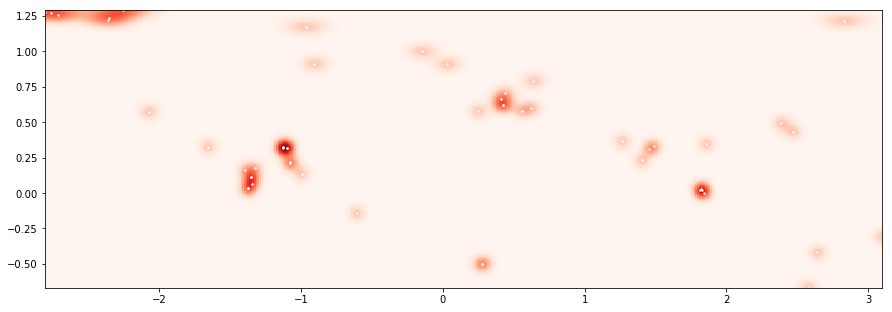

In [350]:
r.showKDE()

In [351]:
hk_to_southampton = [
          [
            114.697265625,
            21.616579336740603
          ],
          [
            105.380859375,
            0.3515602939922709
          ],
          [
            101.513671875,
            2.3723687086440504
          ],
          [
            97.55859375,
            6.315298538330033
          ],
          [
            91.7578125,
            5.353521355337334
          ],
          [
            80.68359375,
            5.090944175033399
          ],
          [
            54.052734375,
            13.325484885597936
          ],
          [
            47.8125,
            12.382928338487396
          ],
          [
            44.29687499999999,
            11.996338401936226
          ],
          [
            42.451171875,
            13.624633438236152
          ],
          [
            35.5517578125,
            25.720735134412106
          ],
          [
            32.7392578125,
            29.075375179558346
          ],
          [
            32.4755859375,
            30.259067203213018
          ],
          [
            32.2119140625,
            32.10118973232094
          ],
          [
            24.345703125,
            33.94335994657882
          ],
          [
            13.798828125,
            35.60371874069731
          ],
          [
            10.8984375,
            37.71859032558816
          ],
          [
            -3.6035156249999996,
            36.10237644873644
          ],
          [
            -7.470703125,
            36.10237644873644
          ],
          [
            -10.986328125,
            37.50972584293751
          ],
          [
            -10.1953125,
            43.77109381775651
          ],
          [
            -5.2734375,
            48.980216985374994
          ],
          [
            -1.318359375,
            50.45750402042058
          ]
        ]

In [352]:
hk2sh = shapely.geometry.linestring.LineString(hk_to_southampton)

In [355]:
hk2sh_risk_kde = r.calcRiskScoreKDE(hk2sh)
hk2sh_risk_quadrat = r.calcRiskScoreQuadrat(hk2sh)

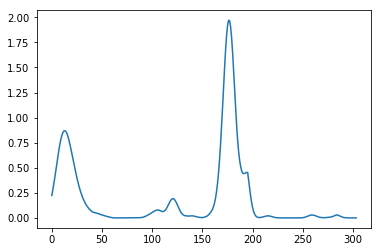

In [356]:
plt.plot(hk2sh_risk['risk_score'])

In [366]:
hk2sh_q = hk2sh_risk_quadrat[0][hk2sh_risk_quadrat[0] > 0]

In [269]:
risks['risk_score'].sum() / len(risks['risk_score'])

0.4557568853248999

In [126]:
list(routeLine.interpolate(risks['along'][4]).coords)

[(1.0036855022719056, 0.2760588798499759)]

In [129]:
risks

,along
0,0.00
1,0.01
2,0.02
3,0.03
4,0.04
5,0.05
6,0.06
7,0.07
8,0.08
9,0.09


In [253]:
cellSize = 10
lats = np.arange(-90, 90 + cellSize, cellSize, dtype=np.single)
lons = np.arange(-180, 180 + cellSize, cellSize, dtype=np.single)

multiindex = pd.MultiIndex.from_product([lons.tolist(), lats.tolist()], names=['lons', 'lats'])
grid = gpd.GeoDataFrame(index=multiindex, columns = ['geometry'])
grid['gaussian_kde'] = gpd.GeoSeries(np.zeros(len(grid.index)), index=grid.index)

h = 1

In [256]:
df_teensy = df_tiny.sample(frac=0.1)

In [262]:
x = grid.index[0][0]
y = grid.index[0][1]

cellSum = [0,0]
for i in df_teensy.sample(frac=0.1)[['lon_centroid', 'lat_centroid']].iterrows():
    xi = i[1].lon_centroid
    yi = i[1].lat_centroid
    print (xi, yi)
    cellSum[0] += math.e ** (((x - xi) / h) ** 2 ) / math.sqrt(2 * math.pi)
    cellSum[1] += math.e ** (((y - yi) / h) ** 2 ) / math.sqrt(2 * math.pi)
    #     for 
print(cellSum)


# 

-42.20568596530989 -24.64195083055408
-95.916667 19.018334
-58.812 67.243167
-57.762275497070256 8.625772466097697
57.2664837615276 69.26886579548821
[inf, inf]


/Users/iv/anaconda3/envs/GIS/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/Users/iv/anaconda3/envs/GIS/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [265]:
xi = -42.20568596530989
x = -180
h = 1
gauss = math.e ** -(((x - xi) / h) ** 2 ) / math.sqrt(2 * math.pi)
print(gauss)

0.0


In [269]:
math.e ** ((-1 / 2 ) * ((x - xi) / h) ** 2)

0.0

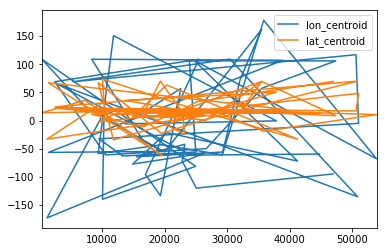

In [261]:
df_teensy[['lon_centroid', 'lat_centroid']]


In [271]:
from sklearn.neighbors import KernelDensity

 - computing KDE in spherical coordinates


ValueError: NumPy boolean array indexing assignment cannot assign 77517 input values to the 28008 output values where the mask is true

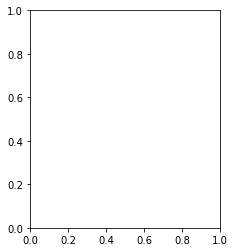

In [309]:
# Author: Jake Vanderplas <jakevdp@cs.washington.edu>
#
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_species_distributions
from sklearn.datasets.species_distributions import construct_grids
from sklearn.neighbors import KernelDensity

# if basemap is available, we'll use it.
# otherwise, we'll improvise later...
try:
    from mpl_toolkits.basemap import Basemap
    basemap = True
except ImportError:
    basemap = False

# Get matrices/arrays of species IDs and locations
data = fetch_species_distributions()
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']

Xtrain = np.vstack([data['train']['dd lat'],
                    data['train']['dd long']]).T
ytrain = np.array([d.decode('ascii').startswith('micro')
                  for d in data['train']['species']], dtype='int')
Xtrain *= np.pi / 180.  # Convert lat/long to radians

# Set up the data grid for the contour plot
xgrid, ygrid = construct_grids(data)
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()

xy = np.vstack([Y.ravel(), X.ravel()]).T
# xy = xy[land_mask]
xy *= np.pi / 180.

# Plot map of South America with distributions of each species
fig = plt.figure()
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)

for i in range(2):
    plt.subplot(1, 2, i + 1)

    # construct a kernel density estimate of the distribution
    print(" - computing KDE in spherical coordinates")
    kde = KernelDensity(bandwidth=0.04, metric='haversine',
                        kernel='gaussian', algorithm='ball_tree')
    kde.fit(Xtrain[ytrain == i])

    # evaluate only on the land: -9999 indicates ocean
    Z = np.full(land_mask.shape[0], -9999, dtype='int')
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)

    if basemap:
        print(" - plot coastlines using basemap")
        m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                    urcrnrlat=Y.max(), llcrnrlon=X.min(),
                    urcrnrlon=X.max(), resolution='c')
        m.drawcoastlines()
        m.drawcountries()
    else:
        print(" - plot coastlines from coverage")
        plt.contour(X, Y, land_reference,
                    levels=[-9998], colors="k",
                    linestyles="solid")
        plt.xticks([])
        plt.yticks([])

    plt.title(species_names[i])

plt.show()

In [302]:
a = []
for i in df_teensy[['lon_centroid', 'lat_centroid']].iterrows():
    lon_rad = i[1].lon_centroid * np.pi / 180
    lat_rad = i[1].lat_centroid * np.pi / 180
    a.append([lon_rad, lat_rad])

In [310]:
kde = KernelDensity(bandwidth=0.04, metric='haversine', 
                    kernel='gaussian', algorithm='ball_tree')
kde.fit(a)

KernelDensity(algorithm='ball_tree', atol=0, bandwidth=0.04,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='haversine', metric_params=None, rtol=0)